# Overfitting

<!-- <a href="https://en.wikipedia.org/wiki/Linear_least_squares_(mathematics)">Wikipedia</a>
[Polynomial 수식 유도](http://mathworld.wolfram.com/LeastSquaresFittingPolynomial.html)
-->

In [439]:
# https://en.wikipedia.org/wiki/Linear_least_squares_(mathematics)
# http://mathworld.wolfram.com/LeastSquaresFittingPolynomial.html
#Motivational_example

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# retrun: [1 x x^2 ... x^k] (shape= (N,1+k))
def buildX(x, k):
    x = np.array(x) if type(x) is list else x
    X = np.ones_like(x)
    #X = np.ones(len(x), 1)
    
    for i in range(k):
        X = np.vstack((X, np.power(x, i + 1)))
    
    return X.T

# return: compute polynomial (shape= (N,1))
def evaluate(a, x):
    y = np.zeros(x.shape[0])
    
    for i in range(a.shape[0]):
        y += a[i] * np.power(x, i)
        
    return y

# return: sum of squred error (shape= (1,1))
def sqrErr(d, o):
    return np.sum(np.power(d - o, 2), 0) / 2.

def fit(X, y):
    
    a = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return a

def plot(x, y, a, rangeX, ax=None):
    
    if len(np.array(a).shape) == 0:
        k = 0
    else:
        k = a.shape[0] - 1;
    
    if ax == None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    ax.set_title(u'Fit Polynomial Fn, $k = %d$' % k, fontsize=20)
    ax.set_xlabel(u'$x$', fontsize=15)
    ax.set_ylabel(u'$y$', fontsize=15, rotation='horizontal')
    ax.text(1.05, 1, '\n'.join('$a_%d = %f$' % (i, a[i]) for i in range(k+1)), 
            transform=ax.transAxes, verticalalignment='top', fontsize=15)

    xx = np.linspace(rangeX[0], rangeX[1])
    yy = evaluate(a, xx)
    ax.plot(xx, yy, color='b')

    ax.scatter(x, y, color='r')
    
    o = evaluate(a, x)
    
    err = sqrErr(y, o)
    
    ax.text(0.5, 0.9, u'$E = %f$' % err, fontsize=15, transform=ax.transAxes)
    
    return ax

def plot_f(f, rangeX, ax):
    xx = np.linspace(rangeX[0], rangeX[1])
    yy = f(xx)
    ax.plot(xx, yy, color='g')

In [440]:
def generateData(N, f, rangeX=[-5, 5], noiseLv = 0.1):
    x = np.random.rand(N) * (rangeX[1] - rangeX[0]) + rangeX[0]
    
    noise = np.random.randn(N) * noiseLv
    y = f(x) + noise
    
    return x, y


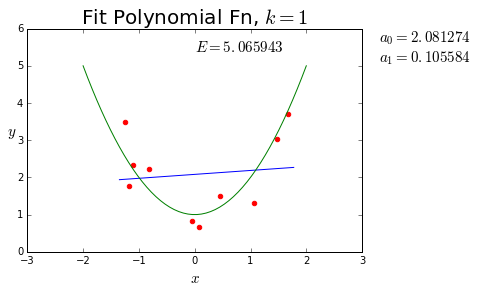

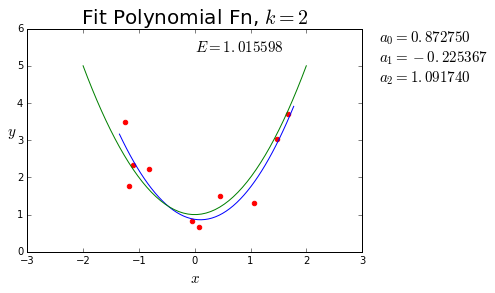

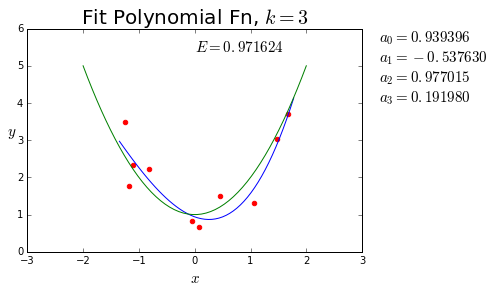

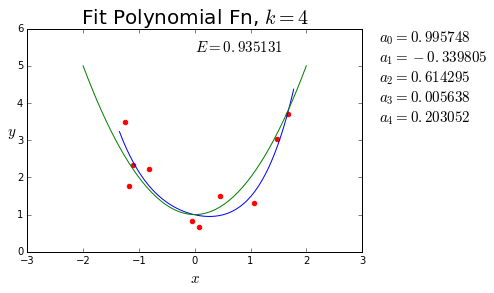

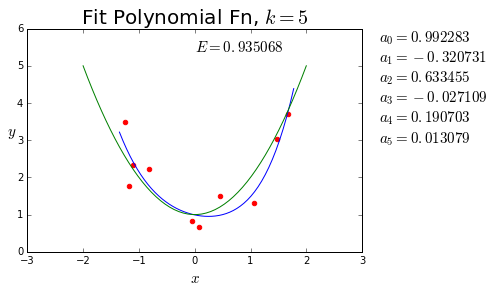

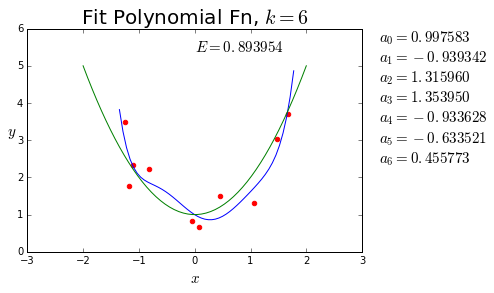

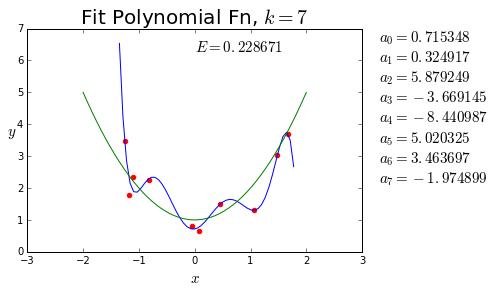

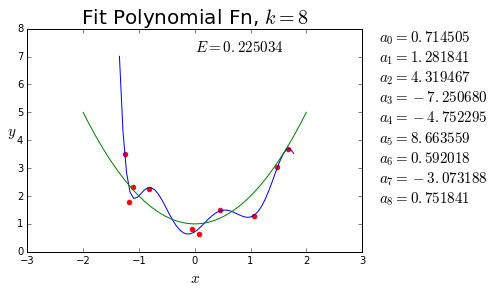

In [441]:
N = 10
f = lambda x: x ** 2 + 1
rangeX = [-2, 2]
np.random.seed(5)
x, y = generateData(N, f, rangeX=rangeX, noiseLv=0.5)



K = 8

for k in range(1, K+1):
    X = buildX(x, k)
    
    a = fit(X, y)
    #a = fit_GD(X, y, 10000, 0.00001, 0.5)
    
    ax = plot(x, y, a, rangeX=[min(x) - 0.1, max(x) + 0.1])
    plot_f(f, rangeX=rangeX, ax=ax)

## Overfitting
데이터 포인트와의 오차(E)는 줄어드는데, 원래 함수와는 점점 더 멀어진다.

* Parameter가 과도하게 크다

### 대책1: Best Model
딱 알맞은 정도로 모델의 복잡도를 설정한다.


### 대책2: More Data
데이터가 더 많으면 괜찮아진다.
N=100으로 해서 돌려보자

### 대책3: Early stop
parameter가 과하게 커지기 전에 중단하자!

In [442]:
from numpy.testing import assert_array_almost_equal as assertEqual

def lossFn(X, y, a):
    if len(X.shape) == 1:
        f = X * a
    else:
        f = evaluate(a, np.array(X[:,1]))
        
    E = sqrErr(f,y)
    return E

def grad(X, y, a):
    if len(X.shape) == 1:
        f = X * a
    else:
        f = np.dot(X,a)
        
    e = y - f
    
    gradE = - e.T.dot(X).T
    
    return gradE


def fit_GD(X, y, epoch, mu, momentum = 0):
    
    if len(X.shape) == 1:
        a = np.random.randn() * 0.01
    else:
        a = np.random.randn(X.shape[1]) * 0.01
    
    E = 0
    
    prevDelta = 0
    for i in range(epoch):
        
        #if (i % (epoch / 10) == 0):
        #    print lossFn(X,y,a)
        
        gradE = grad(X,y,a)
        
        delta = mu * gradE + momentum * prevDelta
        a -= delta

        prevDelta = delta
    
    return a


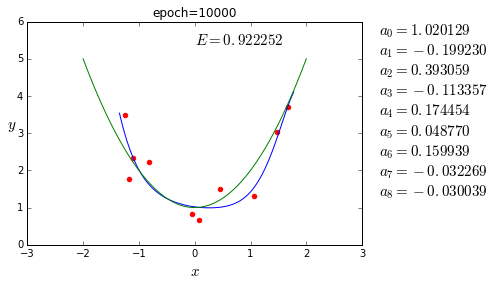

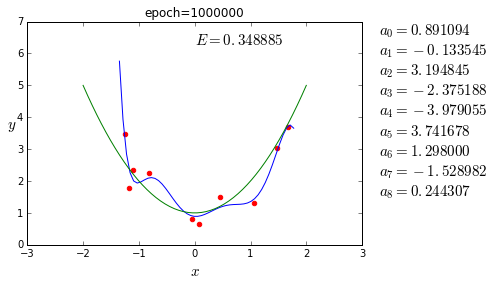

In [443]:
k = 8

X = buildX(x, k)

a = fit_GD(X, y, 10000, 0.0001, 0)

ax = plot(x, y, a, rangeX=[min(x) - 0.1, max(x) + 0.1])
ax.set_title('epoch=10000')
plot_f(f, rangeX=rangeX, ax=ax)

a = fit_GD(X, y, 1000000, 0.0001, 0)

ax = plot(x, y, a, rangeX=[min(x) - 0.1, max(x) + 0.1])
ax.set_title('epoch=1000000')
plot_f(f, rangeX=rangeX, ax=ax)

### 대책4: Regularization
파라미터가 못 커지게 하자!

loss function에 파라미터가 커지면 값이 커지게 하는 페널티를 준다.

$$ E_{L_1} = E + \lambda \sum \left| a_i \right| $$
$$ E_{L_2} = E + \lambda \sum a_i ^ 2$$

In [444]:
def lossFn_L2(X, y, a, lam):
    if len(X.shape) == 1:
        f = X * a
        sumA = a ** 2
    else:
        f = evaluate(a, np.array(X[:,1]))
        sumA = np.sum(np.power(a, 2))
        
    E = sqrErr(f,y) + lam * sumA
    return E

def grad_L2(X, y, a, lam):
    if len(X.shape) == 1:
        f = X * a
    else:
        f = np.dot(X,a)
        
    e = y - f
    
    gradE = - e.T.dot(X).T + 2 * lam * a
    
    return gradE 

def fit_GD_L2(X, y, epoch, mu, lam = 0, momentum = 0):
    
    if len(X.shape) == 1:
        a = np.random.randn() * 0.01
    else:
        a = np.random.randn(X.shape[1]) * 0.01
    
    E = 0
    
    prevDelta = 0
    for i in range(epoch):
        
        #if (i % (epoch / 10) == 0):
        #    print lossFn_L2(X,y,a,lam)
        
        gradE = grad_L2(X,y,a,lam)
        
        delta = mu * gradE + momentum * prevDelta
        a -= delta

        prevDelta = delta
    
    return a

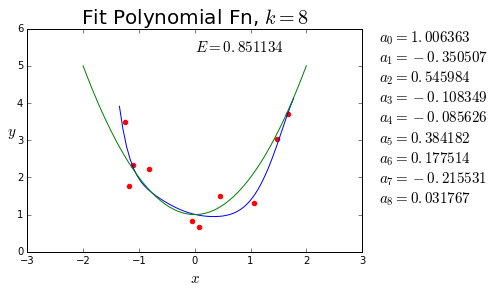

In [445]:
k = 8

X = buildX(x, k)

a = fit_GD_L2(X, y, 1000000, 0.0001, 0.1)

ax = plot(x, y, a, rangeX=[min(x) - 0.1, max(x) + 0.1])
plot_f(f, rangeX=rangeX, ax=ax)

## Test Data & Validation Data

Overfitting 대책 중에서, Best Model을 찾거나 Early Stop 하려면 데이터의 원래 함수(녹색 선)을 알고 있어야 하는데, 이건 알 수 없는 건데? 정답을 알고 있는데 fitting을 왜 하고 있겠냐?

-> 학습된 모델을 평가할 때는 학습 데이터와 같은 함수에서 뽑아낸 (뽑아 냈다고 생각되는) 다른 데이터 셋을 사용하자!

- Test dataset : 학습이 끝난 모델을 평가할 때 사용
- Validataion dataset: 학습 중에 모델을 평가할 때 사용

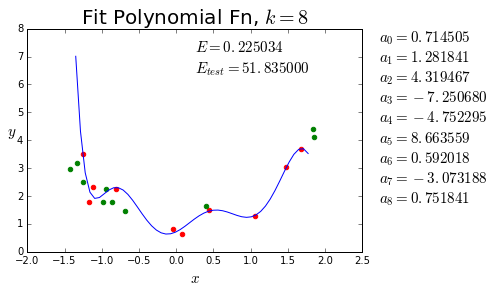

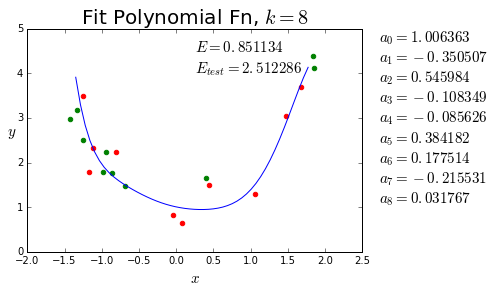

In [446]:
N = 10
f = lambda x: x ** 2 + 1
rangeX = [-2, 2]
np.random.seed(5)
x, y = generateData(N, f, rangeX=rangeX, noiseLv=0.5)
testX, testY = generateData(N, f, rangeX=rangeX, noiseLv=0.5)

a = fit(X, y)

testE = lossFn(buildX(testX,k), testY, a)
ax = plot(x, y, a, rangeX=[min(x) - 0.1, max(x) + 0.1])
ax.scatter(testX, testY, color='g')
ax.text(0.5, 0.8, u'$E_{test} = %f$' % testE, fontsize=15, transform=ax.transAxes)


a = fit_GD_L2(X, y, 1000000, 0.0001, 0.1)

testE = lossFn(buildX(testX,k), testY, a)
ax = plot(x, y, a, rangeX=[min(x) - 0.1, max(x) + 0.1])
ax.scatter(testX, testY, color='g')
ax.text(0.5, 0.8, u'$E_{test} = %f$' % testE, fontsize=15, transform=ax.transAxes)


# Curse of Dimensionality

https://drive.google.com/open?id=0BzU6LSYvfhGJb0c0Q3BPSDhNU1k  
https://drive.google.com/open?id=0BzU6LSYvfhGJWlhzOTduSksxUms  
https://drive.google.com/open?id=0BzU6LSYvfhGJd1lHX1dWLUhidjQ  